# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


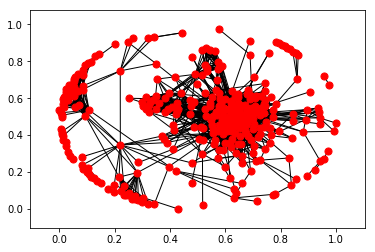

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

## 2. Data Preprocessing

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Tensorflow Settings (hyperparams) - ONLY RUN THIS CELL ONCE
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0.2, 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

In [10]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [11]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [12]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

## 3. Initialize VAE Model

In [13]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [14]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [15]:
# Create VAE model
with tf.name_scope('optimizer'):
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

    opt = OptimizerVAE(preds=model.reconstructions,
                               labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                           validate_indices=False), [-1]),
                               model=model, num_nodes=num_nodes,
                               pos_weight=pos_weight,
                               norm=norm)

In [16]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [17]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.78961 train_acc= 0.48624 val_roc= 0.78906 val_ap= 0.78875 time= 0.20697
Epoch: 0002 train_loss= 1.72140 train_acc= 0.48691 val_roc= 0.79034 val_ap= 0.78960 time= 0.03521
Epoch: 0003 train_loss= 1.76710 train_acc= 0.48725 val_roc= 0.79258 val_ap= 0.79098 time= 0.04180
Epoch: 0004 train_loss= 1.65797 train_acc= 0.48000 val_roc= 0.79424 val_ap= 0.79251 time= 0.10399
Epoch: 0005 train_loss= 1.71552 train_acc= 0.48870 val_roc= 0.79622 val_ap= 0.79484 time= 0.07199
Epoch: 0006 train_loss= 1.62914 train_acc= 0.48693 val_roc= 0.79827 val_ap= 0.79659 time= 0.10041
Epoch: 0007 train_loss= 1.61188 train_acc= 0.48330 val_roc= 0.80026 val_ap= 0.79853 time= 0.03727
Epoch: 0008 train_loss= 1.62593 train_acc= 0.48740 val_roc= 0.80230 val_ap= 0.80049 time= 0.03818
Epoch: 0009 train_loss= 1.63109 train_acc= 0.48435 val_roc= 0.80435 val_ap= 0.80228 time= 0.05756
Epoch: 0010 train_loss= 1.51630 train_acc= 0.47959 val_roc= 0.80736 val_ap= 0.80499 time= 0.06796
Epoch: 0011 train_lo

Epoch: 0087 train_loss= 0.61358 train_acc= 0.51510 val_roc= 0.88102 val_ap= 0.86194 time= 0.03265
Epoch: 0088 train_loss= 0.61955 train_acc= 0.50091 val_roc= 0.88064 val_ap= 0.86238 time= 0.05682
Epoch: 0089 train_loss= 0.60664 train_acc= 0.52116 val_roc= 0.88064 val_ap= 0.86266 time= 0.06891
Epoch: 0090 train_loss= 0.60328 train_acc= 0.51277 val_roc= 0.88090 val_ap= 0.86290 time= 0.09448
Epoch: 0091 train_loss= 0.61289 train_acc= 0.49945 val_roc= 0.88090 val_ap= 0.86285 time= 0.05710
Epoch: 0092 train_loss= 0.60423 train_acc= 0.49925 val_roc= 0.88147 val_ap= 0.86364 time= 0.03567
Epoch: 0093 train_loss= 0.60453 train_acc= 0.51793 val_roc= 0.88115 val_ap= 0.86385 time= 0.03073
Epoch: 0094 train_loss= 0.59609 train_acc= 0.51294 val_roc= 0.88096 val_ap= 0.86400 time= 0.02577
Epoch: 0095 train_loss= 0.59288 train_acc= 0.52033 val_roc= 0.88147 val_ap= 0.86461 time= 0.02459
Epoch: 0096 train_loss= 0.59087 train_acc= 0.52461 val_roc= 0.88166 val_ap= 0.86515 time= 0.04666
Epoch: 0097 train_lo

Epoch: 0172 train_loss= 0.56108 train_acc= 0.54125 val_roc= 0.88422 val_ap= 0.86999 time= 0.17764
Epoch: 0173 train_loss= 0.55819 train_acc= 0.54096 val_roc= 0.88448 val_ap= 0.87016 time= 0.06261
Epoch: 0174 train_loss= 0.56166 train_acc= 0.53912 val_roc= 0.88486 val_ap= 0.87073 time= 0.03982
Epoch: 0175 train_loss= 0.55903 train_acc= 0.53846 val_roc= 0.88506 val_ap= 0.87133 time= 0.02862
Epoch: 0176 train_loss= 0.56288 train_acc= 0.53570 val_roc= 0.88512 val_ap= 0.87137 time= 0.02889
Epoch: 0177 train_loss= 0.56681 train_acc= 0.53332 val_roc= 0.88525 val_ap= 0.87201 time= 0.03257
Epoch: 0178 train_loss= 0.56386 train_acc= 0.52805 val_roc= 0.88506 val_ap= 0.87182 time= 0.03602
Epoch: 0179 train_loss= 0.56188 train_acc= 0.53862 val_roc= 0.88525 val_ap= 0.87233 time= 0.05012
Epoch: 0180 train_loss= 0.56256 train_acc= 0.53734 val_roc= 0.88525 val_ap= 0.87205 time= 0.02472
Epoch: 0181 train_loss= 0.55640 train_acc= 0.54500 val_roc= 0.88448 val_ap= 0.87150 time= 0.02970
Epoch: 0182 train_lo